Expecation Maximization
====

In [1]:
np.random.seed(1234)
np.set_printoptions(formatter={'all':lambda x: '%.3f' % x})

In [2]:
from IPython.display import Image
from numpy.core.umath_tests import matrix_multiply as mm

In [3]:
from scipy.optimize import minimize
from scipy.stats import bernoulli, binom

Outline
----

- Review of Jensen's inequality
- Concavity of log function
- Example of coin tossing with missing information to provide context
- Derivation of EM equations
- Illustration of EM convergence
- Derivation of update equations of coin tossing example
- Code for coin tossing example
- Warm up: The k-means algorithm
- Derivation of update equations for mixture of Gaussians
- Code for mixture of Gaussians

Jensen's inequality
----

For a convex function $f$, $E[f(x) \geq f(E[x])$. Flip the signs for a concave function. 

A function $f(x)$ is convex if $f''(x) \geq 0$ everywhere in its domain. For example, if $f(x) = \log x$, $f''(x) = -1/x^2$, so the log function is concave for $x \in (0, \infty]$. A visual illustration of Jensen's inequality is shown below.


In [4]:
from sympy import symbols, diff, log, init_printing
init_printing()

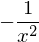

In [5]:
x = symbols('x')
diff(log(x), x, 2)

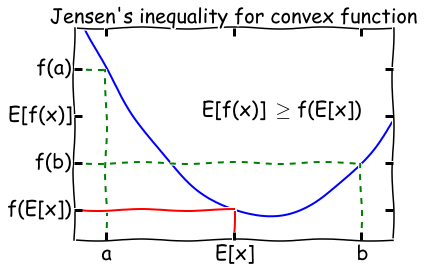

In [6]:
Image(filename='jensen.png')

When is Jensen's inequality an equality? From the diagram, we can see that this only happens if the function $f(x)$ is a constant! We will make use of this fact later on in the lecture.

Maximum likelihood with complete information
----

Consider an experiment with coin $A$ that has a probability $\theta_A$ of heads, and a coin $B$ that has a probability $\theta_B$ of tails. We draw $m$ samples as follows - for each sample, pick one of the coins, flip it 10 times, and record the number of heads and tails. If we recorded which coin we used for each sample, we have *complete* information and can estimate $\theta_A$ and $\theta_B$ in closed form. To be very explicit, suppose we drew 5 samples with the $m$ values represented as a vector $x$, and the sequence of coins chosen was $A, A, B, A, B$. Then the complete log likelihood is 

$$
\log p(x_1; \theta_A) + \log p(x_2; \theta_A) +\ log p(x_3; \theta_B) + \log p(x_4; \theta_A) +\log p(x_5; \theta_B)
$$

where $p(x_i; \theta)$ is the binomial distribution PMF with $n=m$ and $p=\theta$. We will use $z_i$ to indicate the label of the $i^\text{th}$ coin, that is - whether we used coin $A$ or $B$ to generate the $i^\text{th}$ sample.

### Solving for complete likelihood using minimization

In [7]:
def neg_loglik(thetas, n, xs, zs):
    return -np.sum([binom(n, thetas[z]).logpmf(x) for (x, z) in zip(xs, zs)])

In [8]:
m = 10
theta_A = 0.8
theta_B = 0.3
theta_0 = [theta_A, theta_B]

coin_A = bernoulli(theta_A)
coin_B = bernoulli(theta_B)

flips = np.array([coin_A.rvs(m), 
                  coin_A.rvs(m), 
                  coin_B.rvs(m), 
                  coin_A.rvs(m), 
                  coin_B.rvs(m)])
xs = flips.sum(1)
zs = np.array([0,0,1,0,1])
list(xs)

[7, 9, 2, 6, 0]

#### Analytic solution

In [9]:
np.mean(xs[zs==0]/m)

In [10]:
np.mean(xs[zs==1]/m)

#### Finding parameters by optimization

In [11]:
bnds = [(0,1), (0,1)]
minimize(neg_loglik, [0.5, 0.5], args=(m, xs, zs), 
         bounds=bnds, method='tnc', options={'maxiter': 100})

       x: array([0.733, 0.100])
 message: 'Converged (|f_n-f_(n-1)| ~= 0)'
    nfev: 17
  status: 1
     nit: 6
     jac: array([-0.000, -0.000])
     fun: 7.6552677541393193
 success: True

Incomplete information
----

However, if we did not record the coin we used, we have *missing* data and the problem is harder to solve. One way to approach the problem is to ask - can we assign weights $w_i$ to each sample according to how likely it is to be generated from coin $A$ or coin $B$? Intuitively, it seems that the weights should be the posterior distribution of $z_i$, that is

$$
w_i = p(z_i \ | \ x_i; \theta)
$$

Assuming we have some estimate of $\theta$, if we know $z_i$, then we can estimate $\theta$ since we have the complete likelihood as above. So the basic idea behind Expectation Maximization (EM) is simply to start with a guess for $\theta$, then calculate $z$, then update $\theta$ using this new value for $z$, and repeat till convergence. The derivation below shows why the EM algorithm using this "alternating" updates actually works.

A verbal outline of the derivation - first consider the log likelihood function as a curve (surface) where the x-axis is $\theta$. Find another function $Q$ of $\theta$ that is a lower bound of the log-likelihood but touches the log likelihood function at some $\theta$ (E-step). Next find the value of $\theta$ that maximizes this function (M-step). Now find yet another function of $\theta$ that is a lower bound of the log-likelihood but touches the log likelihood function at this new $\theta$. Repeat until convergence - at this point, the maxima of the lower bound and likelihood functions are the same and we have found the maximum log likelihood. See illustration below. 

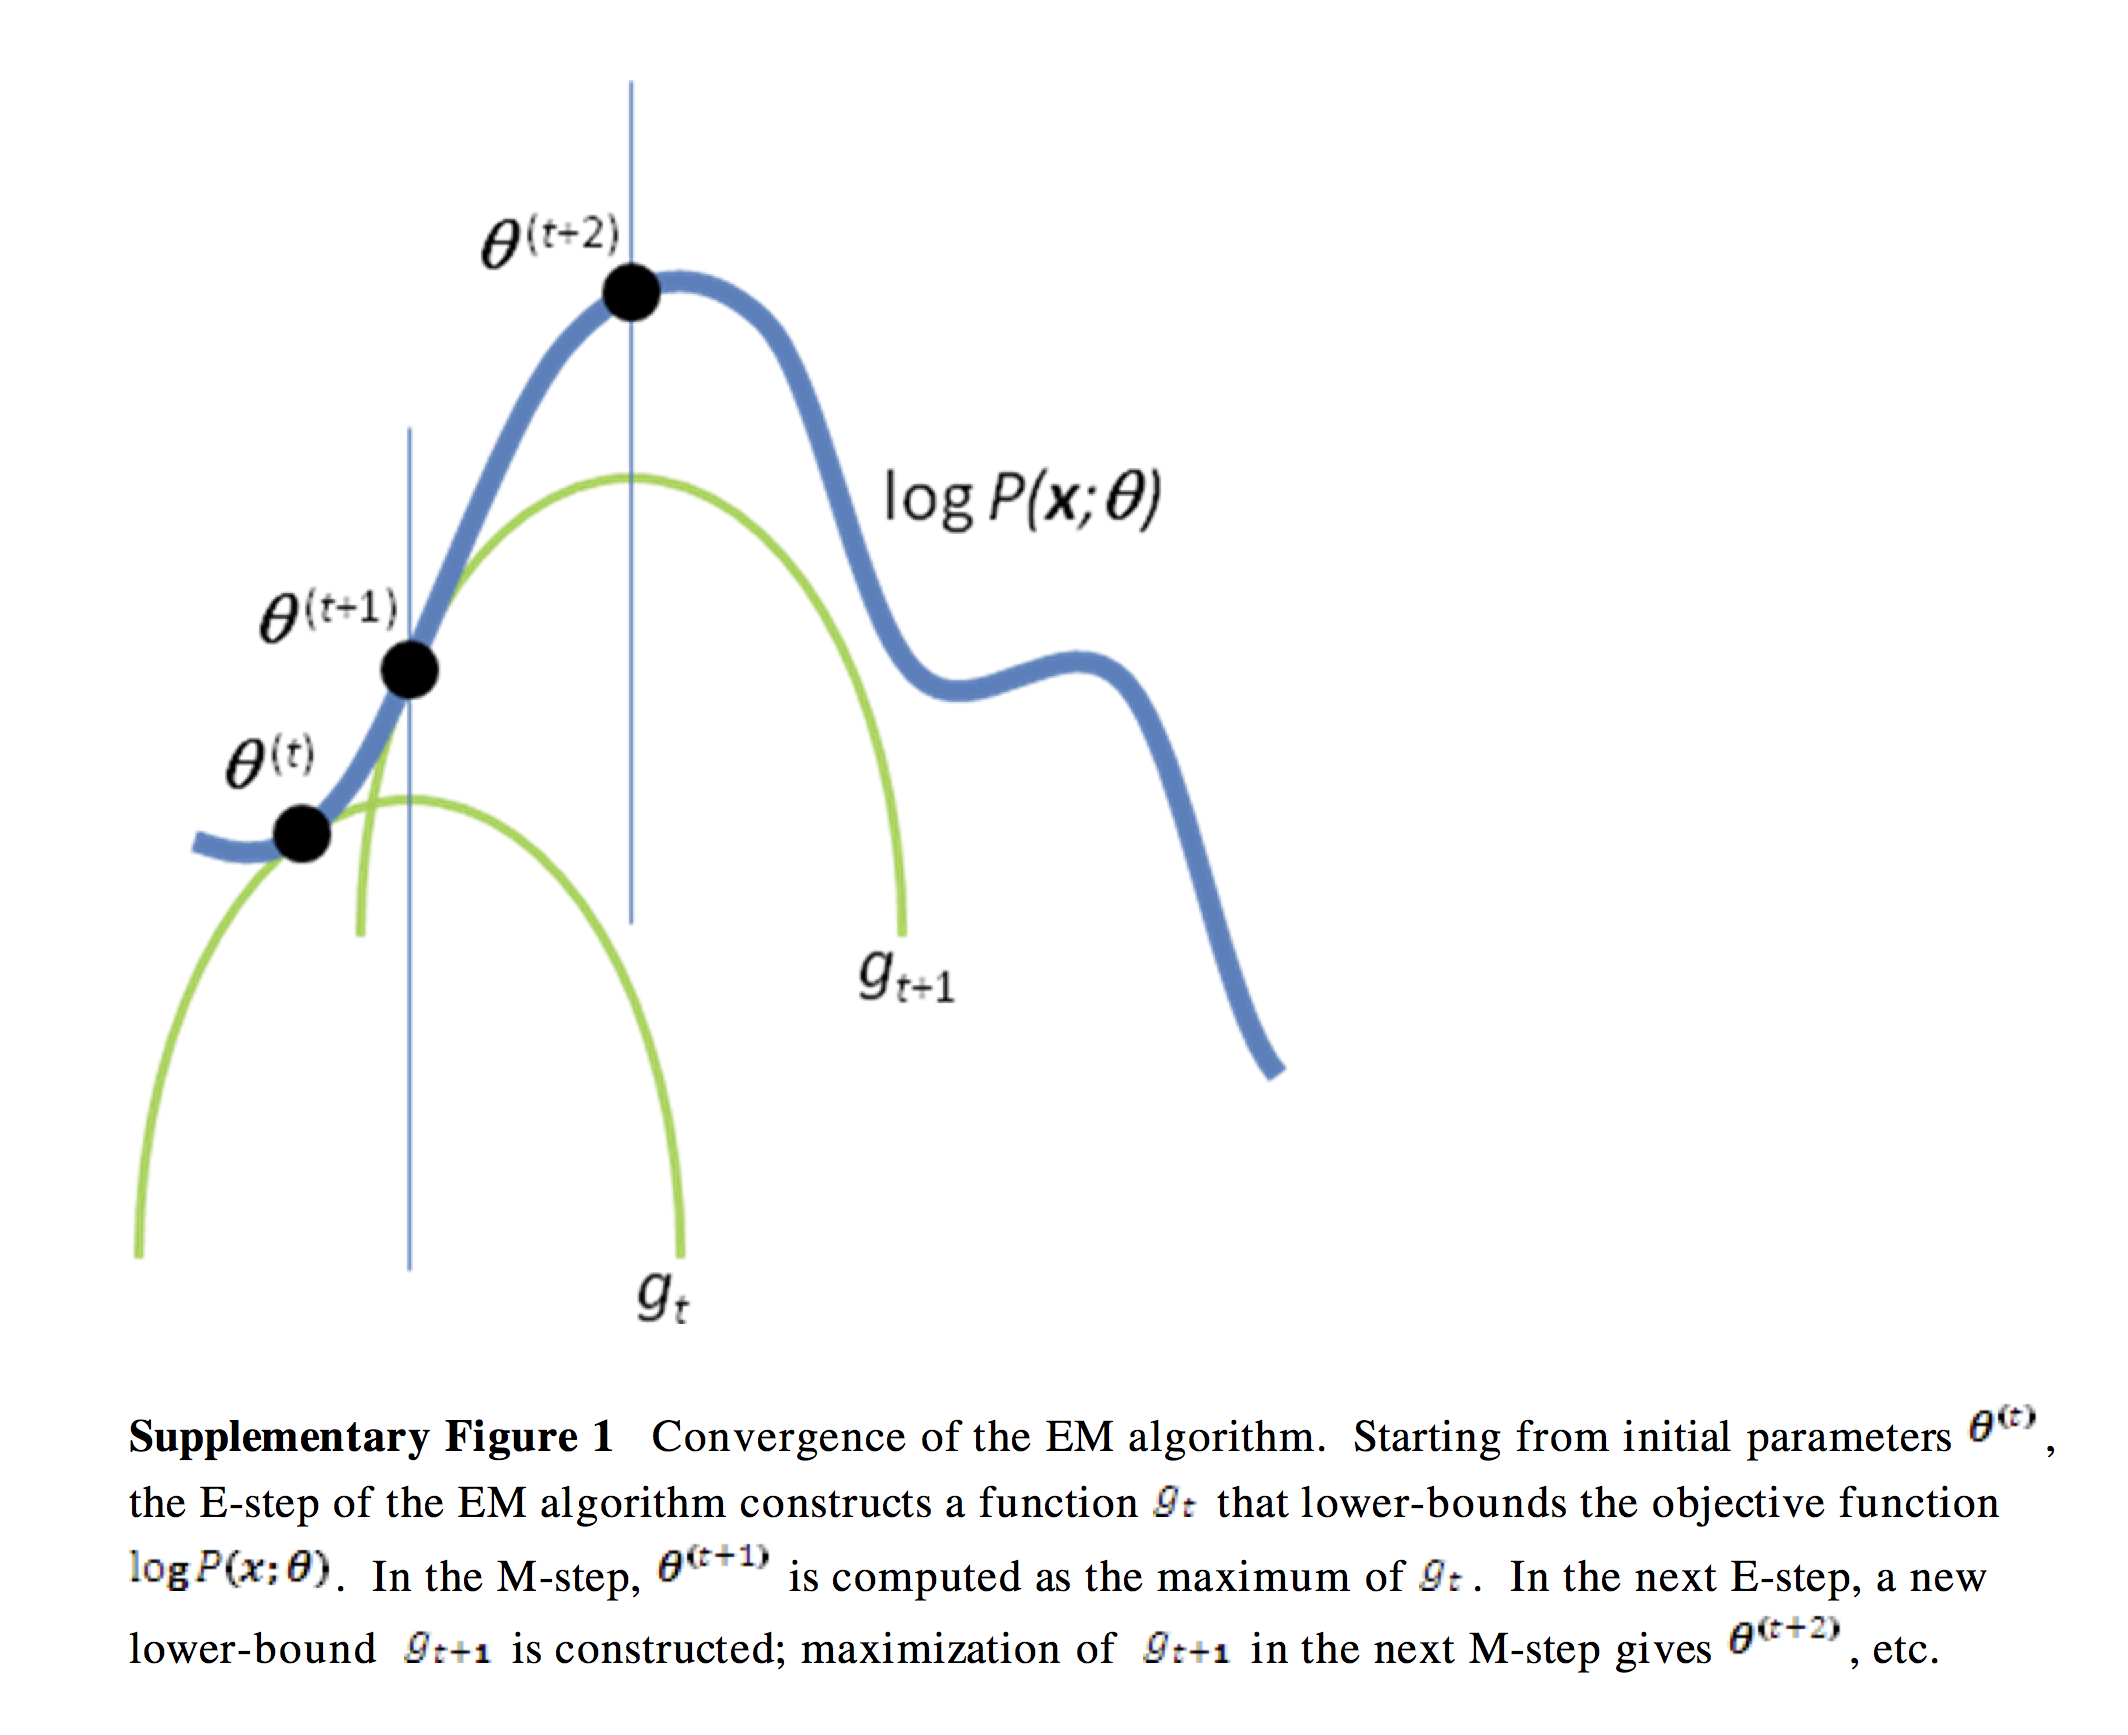

In [12]:
# Image from http://www.nature.com/nbt/journal/v26/n8/extref/nbt1406-S1.pdf
Image(filename='em.png', width=800)

The only remaining step is how to find the functions that are lower bounds of the log likelihood. This will require a little math using Jensen's inequality, and is shown in the next section.

### Derivation

In the E-step, we identify a function which is a lower bound for the log-likelihood

$$
\begin{align}
l &= \sum_i{\log p(x_i; \theta)} && \text{definition of log likelihood} \\
&= \sum_i \log \sum_{z_i}{p(x_i, z_i; \theta)} && \text{augment with latent variables $z$} \\
&= \sum_i \log \sum_{z_i} Q_i(z_i) \frac{p(x_i, z_i; \theta)}{Q_i(z_i)} && \text{$Q_i$ is a distribution for $z_i$} \\
&= \sum_i \log E_{z_i}[\frac{p(x_i, z_i; \theta)}{Q_i(z_i)}] && \text{taking expectations - hence the E in EM} \\
&\geq \sum E_{z_i}[\log \frac{p(x_i, z_i; \theta)}{Q_i(z_i)}] && \text{Using Jensen's rule for $\log$ which is concave} \\
&\geq \sum_i \sum_{z_i} Q_i(z_i) \log \frac{p(x_i, z_i; \theta)}{Q_i(z_i)} && \text{definition of expectation}
\end{align}
$$

How do we choose the distribution $Q_i$? We want the Q function to touch the log-likelihood, and know that Jensen's inequality is an equality only if the function is constant. So

$$
\begin{align}
\frac{p(x_i, z_i; \theta)}{Q_i(z_i)} =& c \\
\implies Q_i(z_i) &\propto p(x_i, z_i; \theta)\\
\implies Q_i(z_i) &= \frac{p(x_i, z_i; \theta) }{\sum_{z_i}{p(x_i, z_i; \theta)}} &&\text{Since $Q$ is a distribution and sums to 1} \\
\implies Q_i(z_i) &= \frac{p(x_i, z_i; \theta) }{{p(x_i, \theta)}} && \text{marginalizing $z_i$}\\
\implies Q_i(z_i) &= p(z_i | x_i; \theta) && \text{by definition of conditional probability}
\end{align}
$$

So $Q_i$ is just the posterior distribution of $z_i$, and this completes the E-step.

In the M-step, we find the value of $\theta$ that maximizes the function that is the lower bound of the log likelihood ($g$ in the figure above), and then we iterate over the E and M steps until convergence. 

So we see that EM is an algorithm for maximum likelihood optimization when there is missing information - or when it is useful to add latent augmented variables to simplify maximum likelihood calculations.

#### Coin toss example from [What is the expectation maximization algorithm?](http://www.nature.com/nbt/journal/v26/n8/full/nbt1406.html)

For the E-step, we have

$$
\begin{align}
w_j &= Q_i(z_i = j) \\
&= p(z_i = j \mid x_i; \theta) \\
&= \frac{p(x_i \mid z_i = j; \theta) p(z_i = j; \phi)}  {\sum_{l=1}^k{p(x_i \mid z_i = l; \theta) p(z_i = l; \phi)}}  && \text{Baye's rule} \\
&= \frac{\theta_j^h(1-\theta_j)^{n-h} \phi_j}{\sum_{l=1}^k \theta_l^h(1-\theta_l)^{n-h} \phi_l} && \text{Binomial distribution} \\
&= \frac{\theta_j^h(1-\theta_j)^{n-h} }{\sum_{l=1}^k \theta_l^h(1-\theta_l)^{n-h} } && \text{assume $\phi$ is fixed for simplicity}
\end{align}
$$

For the M-step, we need to find the value of $\theta$ that maximizes

$$
\begin{align}
& \sum_i \sum_{z_i} Q_i(z_i) \log \frac{p(x_i, z_i; \theta)}{Q_i(z_i)} \\
&= \sum_{i=1}^m \sum_{j=1}^k w_j \log \frac{p(x_i \mid z_i=j; \theta) \, p(z_i = j; \phi)}{w_j} \\
&= \sum_{i=1}^m \sum_{j=1}^k w_j \log \frac{\theta_j^h(1-\theta_j)^{n-h} \phi_j}{w_j} \\
&= \sum_{i=1}^m \sum_{j=1}^k w_j \left( h \log \theta_j + (n-h) \log (1-\theta_j) + \log \phi_j - \log w_j \right)
\end{align}
$$

We can differentiate and solve for $\theta_s$ where the derivative vanishes

$$
\begin{align}
\sum_{i=1}^m w_s \left( \frac{h}{\theta_s} - \frac{n-h}{1-\theta_s} \right) &= 0  \\
\implies \theta_s &= \frac {\sum_{i=1}^m w_s h}{\sum_{i=1}^m w_s n}
\end{align}
$$

### First explicit solution

In [13]:
def mn_ll(y, theta, axis=None):
    """Log likelihood for multinomial distribution (ignoring constant)."""
    return np.sum(y * np.log(theta), axis=axis)

def ll(y, theta, p):
    """Complete log likelihood for mixture."""
    return np.sum(p * mm_ll(y, theta))

def normalize(xs, axis=1):
    """Return normalized marirx so that sum of row or column (default) entries = 1."""
    if axis==0:
        return xs/xs.sum(0)
    else:
        return xs/xs.sum(1)[:, None]

In [14]:
xs = np.array([(5,5), (9,1), (8,2) , (4,6), (7,3)])
thetas = np.array([[0.6, 0.4], [0.5, 0.5]])

tol = 0.01
max_iter = 100

ll_old = 0
for i in range(max_iter):
    exp_A = []
    exp_B = []
    
    lls_A = []
    lls_B = []
    
    ws_A = []
    ws_B = []
    
    ll_new = 0

    # E-step: calculate probability distributions over possible completions
    for x in xs:

        ll_A = mn_ll(x, thetas[0])
        ll_B = mn_ll(x, thetas[1])
      
        lls_A.append(ll_A)
        lls_B.append(ll_B)
        
        denom = np.exp(ll_A) + np.exp(ll_B)       
        w_A = np.exp(ll_A)/denom
        w_B = np.exp(ll_B)/denom
        
        ws_A.append(w_A)
        ws_B.append(w_B)

        exp_A.append(np.dot(w_A, x))
        exp_B.append(np.dot(w_B, x))
        
        # update complete log likelihood
        ll_new += w_A * ll_A + w_B * ll_B
    
    # M-step: update values for parameters given current distribution
    thetas[0] = np.sum(exp_A, 0)/np.sum(exp_A)
    thetas[1] = np.sum(exp_B, 0)/np.sum(exp_B)

    # print distribution of z for each x and current parameter estimate 
    print("Iteration: %d" % (i+1))
    print("theta_A = %.2f, theta_B = %.2f, ll = %.2f" % (thetas[0,0], thetas[1,0], ll_new))

    if np.abs(ll_new - ll_old) < tol:
        break
    ll_old = ll_new

Iteration: 1
theta_A = 0.71, theta_B = 0.58, ll = -32.69
Iteration: 2
theta_A = 0.75, theta_B = 0.57, ll = -31.26
Iteration: 3
theta_A = 0.77, theta_B = 0.55, ll = -30.76
Iteration: 4
theta_A = 0.78, theta_B = 0.53, ll = -30.33
Iteration: 5
theta_A = 0.79, theta_B = 0.53, ll = -30.07
Iteration: 6
theta_A = 0.79, theta_B = 0.52, ll = -29.95
Iteration: 7
theta_A = 0.80, theta_B = 0.52, ll = -29.90
Iteration: 8
theta_A = 0.80, theta_B = 0.52, ll = -29.88
Iteration: 9
theta_A = 0.80, theta_B = 0.52, ll = -29.87


### Vectorizing ...

In [15]:
xs = np.array([(5,5), (9,1), (8,2), (4,6), (7,3)])
thetas = np.array([[0.6, 0.4], [0.5, 0.5]])

tol = 0.01
max_iter = 100

ll_old = -np.infty
for i in range(max_iter):
    ll_A = np.sum(xs * np.log(thetas[0]), axis=1)
    ll_B = np.sum(xs * np.log(thetas[1]), axis=1)
    denom = np.exp(ll_A) + np.exp(ll_B)
    w_A = np.exp(ll_A)/denom
    w_B = np.exp(ll_B)/denom

    exp_A = w_A[:, None] * xs
    exp_B = w_B[:, None] * xs
    
    thetas[0] = np.sum(exp_A, 0)/np.sum(exp_A)
    thetas[1] = np.sum(exp_B, 0)/np.sum(exp_B)

    ll_new = w_A.dot(ll_A) + w_B.dot(ll_B)
    
    print("Iteration: %d" % (i+1))
    print("theta_A = %.2f, theta_B = %.2f, ll = %.2f" % (thetas[0,0], thetas[1,0], ll_new))
    
    if np.abs(ll_new - ll_old) < tol:
        break
    ll_old = ll_new

Iteration: 1
theta_A = 0.71, theta_B = 0.58, ll = -32.69
Iteration: 2
theta_A = 0.75, theta_B = 0.57, ll = -31.26
Iteration: 3
theta_A = 0.77, theta_B = 0.55, ll = -30.76
Iteration: 4
theta_A = 0.78, theta_B = 0.53, ll = -30.33
Iteration: 5
theta_A = 0.79, theta_B = 0.53, ll = -30.07
Iteration: 6
theta_A = 0.79, theta_B = 0.52, ll = -29.95
Iteration: 7
theta_A = 0.80, theta_B = 0.52, ll = -29.90
Iteration: 8
theta_A = 0.80, theta_B = 0.52, ll = -29.88
Iteration: 9
theta_A = 0.80, theta_B = 0.52, ll = -29.87


### Writing as a function

In [16]:
def em(xs, thetas, max_iter=100, tol=1e-6):
    """Expectation-maximization for coin sample problem."""
    
    ll_old = -np.infty
    for i in range(max_iter):
        ll = np.array([np.sum(xs * np.log(theta), axis=1) for theta in thetas])    
        lik = np.exp(ll)
        ws = lik/lik.sum(0)
        exps = np.array([w[:, None] * xs for w in ws])
        thetas = np.array([expr.sum(0)/expr.sum() for expr in exps])
        ll_new = np.sum([w*l for w, l in zip(ws, ll)])
        if np.abs(ll_new - ll_old) < tol:
            break
        ll_old = ll_new
    return i, thetas, ll_new

### Checking

In [17]:
xs = np.array([(5,5), (9,1), (8,2), (4,6), (7,3)])
thetas = np.array([[0.6, 0.4], [0.5, 0.5]])

i, thetas, ll = em(xs, thetas)
print(i)
for theta in thetas:
    print(theta)
print(ll)

18
[0.797 0.203]
[0.520 0.480]
-29.868676155


### Make up some data

In [18]:
np.random.seed(1234)

n = 100
p0 = 0.8
p1 = 0.35
xs = np.concatenate([np.random.binomial(n, p0, n//2), np.random.binomial(n, p1, n//2)])
xs = np.column_stack([xs, n-xs])
np.random.shuffle(xs)

### EM with multiple random starts

In [19]:
results = [em(xs, np.random.random((2,2))) for i in range(10)]
i, thetas, ll =  sorted(results, key=lambda x: x[-1])[-1]
print(i)
for theta in thetas:
    print(theta)
print(ll)

4
[0.352 0.648]
[0.798 0.202]
-5756.59565198


Mixture Models
----

We will start with a very simple "mixture model" known as k-means. The k-means algorithm does not use EM, but together with the basic understanding of how EM works from the coin toss model, may help you understand how EM for Gaussian Mixture models work.

### K-means

In k-means, we start with a known number of centroids $k$, typically chosen arbitrarily from $k$ of the data points being fitted. In each iteration, we do the following:

1. Find the distance of every other point to the three centroids
2. Assign each data point to its nearest centroid
3. Update the centroid location as the mean of the points assigned to it

The code for k-means is as simple as the above description suggests (see code below). The EM algorithm for fitting a Gaussian Mixture Model is very similar, except that 1) data points are assigned a posterior probability of being associated with a cluster rather than a 0|1 assignment, and 2) we update the parameters $\alpha_j, \mu_j, \Sigma_j$ for each component of the GMM rather than centroid locations (see section below).

Note that both k-means and EM for GMMs can get stuck in local optima, and multiple random restarts are recommended.

In [20]:
from numpy.core.umath_tests import inner1d

def kmeans(xs, k, max_iter=10):
    """K-means algorihtm."""
    idx = np.random.choice(len(xs), k, replace=False)
    cs = xs[idx]
    for n in range(max_iter):
        ds = np.array([inner1d(xs-c, xs-c) for c in cs])
        zs = np.argmin(ds, axis=0)
        cs = np.array([xs[zs==i].mean(axis=0) for i in range(k)])
    return (cs, zs)

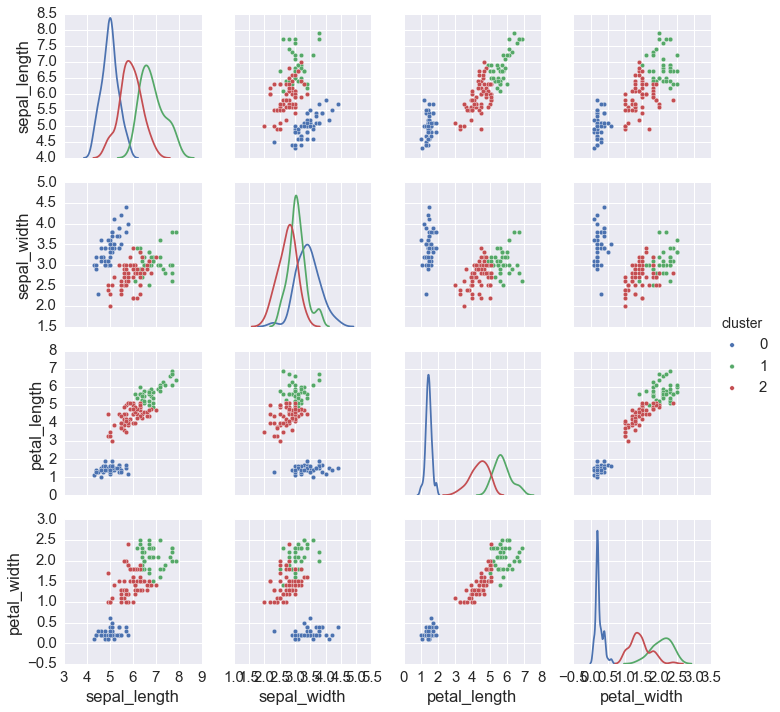

In [21]:
np.random.seed(123)

iris = sns.load_dataset('iris')
data = iris.ix[:, :4].values
cs, zs = kmeans(data, 3)
iris['cluster'] = zs
sns.pairplot(iris, hue='cluster', diag_kind='kde', vars=iris.columns[:4])
pass

Gaussian mixture models
----

A mixture of $k$ Gaussians has the following PDF

$$
\begin{align}
p(x) = \sum_{j=1}^k \alpha_j \phi(x; \mu_j, \Sigma_j)
\end{align}
$$

where $\alpha_j$ is the weight of the $j^\text{th}$ Gaussian component and 

$$
\begin{align}
\phi(x; \mu, \Sigma) = \frac{1}{(2 \pi)^{d/2}|\Sigma|^{1/2}} \exp \left( -\frac{1}{2}(x-\mu)^T\Sigma^{-1}(x-\mu) \right)
\end{align}
$$

Suppose we observe $y_1, y2, \ldots, y_n$ as a sample from a mixture of Gaussians. The log-likelihood is then

$$
\begin{align}
l(\theta) = \sum_{i=1}^n \log \left( \sum_{j=1}^k \alpha_j \phi(y_i; \mu_j, \Sigma_j) \right)
\end{align}
$$

where $\theta = (\alpha, \mu, \Sigma)$

There is no closed form for maximizing the parameters of this log-likelihood, and it is hard to maximize directly because the sum is inside the log function.

Using EM
----

Suppose we augment with the latent variable $z$ that indicates which of the $k$ Gaussians our observation $y$ came from. The derivation of the E and M steps are the same as for the toy example, only with more algebra.

For the E-step, we want to calculate the posterior probability that point $x_i$ belongs in cluster $j$, given the parameters $\theta = (\alpha, \mu, \Sigma)$

$$
\begin{align}
w_j^i &= Q_i(z^i = j) \\
&= p(z^i = j \mid y^i; \theta) \\
&= \frac{p(x^i \mid z^i = j; \mu, \Sigma) p(z^i = j; \alpha)}  {\sum_{l=1}^k{p(y^i \mid z^i = l; \mu, \Sigma) p(z^i = l; \alpha)}}  && \text{Baye's rule} \\
&= \frac{\phi(x^i; \mu_j, \Sigma_j) \alpha_j}{\sum_{l=1}^k \phi(x^i; \mu_l, \Sigma_l) \alpha_l}
\end{align}
$$

For the M-step, we have to find $\theta = (w, \mu, \Sigma)$ that maximizes the function that is a lower bound for the true log likelihood

$$
\begin{align}
\sum_{i=1}^{m}\sum_{j=1}^{k} Q(z^i=j) \log \frac{p(x^i \mid z^i= j; \mu, \Sigma) p(z^i=j; \alpha)}{Q(z^i=j)}
\end{align}
$$

By taking derivatives with respect to $(w, \mu, \Sigma)$ respectively and solving (remember to use Lagrange multipliers for the constraint that $\sum_{j=1}^k w_j = 1$), we get

$$
\begin{align}
\alpha_j &= \frac{1}{m} \sum_{i=1}^{m} w_j^i \\
\mu_j &= \frac{\sum_{i=1}^{m} w_j^i x^i}{\sum_{i=1}^{m} w_j^i} \\
\Sigma_j &= \frac{\sum_{i=1}^{m} w_j^i (x^i - \mu)(x^i - \mu)^T}{\sum_{i1}^{m} w_j^i}
\end{align}
$$

In [22]:
from scipy.stats import multivariate_normal as mvn

def normalize(xs, axis=None):
    """Return normalized marirx so that sum of row or column (default) entries = 1."""
    if axis is None:
        return xs/xs.sum()
    elif axis==0:
        return xs/xs.sum(0)
    else:
        return xs/xs.sum(1)[:, None]

def mix_mvn_pdf(xs, pis, mus, sigmas):
    return np.array([pi*mvn(mu, sigma).pdf(xs) for (pi, mu, sigma) in zip(pis, mus, sigmas)])

In [23]:
def em_gmm_orig(xs, pis, mus, sigmas, tol=0.01, max_iter=100):

    n, p = xs.shape
    k = len(pis)

    ll_old = 0
    for i in range(max_iter):
        exp_A = []
        exp_B = []
        ll_new = 0

        # E-step
        ws = np.zeros((k, n))
        for j in range(len(mus)):
            for i in range(n):
                ws[j, i] = pis[j] * mvn(mus[j], sigmas[j]).pdf(xs[i])
        ws /= ws.sum(0)

        # M-step
        pis = np.zeros(k)
        for j in range(len(mus)):
            for i in range(n):
                pis[j] += ws[j, i]
        pis /= n

        mus = np.zeros((k, p))
        for j in range(k):
            for i in range(n):
                mus[j] += ws[j, i] * xs[i]
            mus[j] /= ws[j, :].sum()

        sigmas = np.zeros((k, p, p))
        for j in range(k):
            for i in range(n):
                ys = np.reshape(xs[i]- mus[j], (2,1))
                sigmas[j] += ws[j, i] * np.dot(ys, ys.T)
            sigmas[j] /= ws[j,:].sum()

        # update complete log likelihoood 
        ll_new = 0.0
        for i in range(n):
            s = 0
            for j in range(k):
                s += pis[j] * mvn(mus[j], sigmas[j]).pdf(xs[i])
            ll_new += np.log(s)

        if np.abs(ll_new - ll_old) < tol:
            break
        ll_old = ll_new

    return ll_new, pis, mus, sigmas

Vectorized version
----

In [24]:
def em_gmm_vect(xs, pis, mus, sigmas, tol=0.01, max_iter=100):

    n, p = xs.shape
    k = len(pis)

    ll_old = 0
    for i in range(max_iter):
        exp_A = []
        exp_B = []
        ll_new = 0

        # E-step
        ws = np.zeros((k, n))
        for j in range(k):
            ws[j, :] = pis[j] * mvn(mus[j], sigmas[j]).pdf(xs)
        ws /= ws.sum(0)

        # M-step
        pis = ws.sum(axis=1)
        pis /= n

        mus = np.dot(ws, xs)
        mus /= ws.sum(1)[:, None]

        sigmas = np.zeros((k, p, p))
        for j in range(k):
            ys = xs - mus[j, :]
            sigmas[j] = (ws[j,:,None,None] * mm(ys[:,:,None], ys[:,None,:])).sum(axis=0)
        sigmas /= ws.sum(axis=1)[:,None,None]

        # update complete log likelihoood 
        ll_new = 0
        for pi, mu, sigma in zip(pis, mus, sigmas):
            ll_new += pi*mvn(mu, sigma).pdf(xs)
        ll_new = np.log(ll_new).sum()

        if np.abs(ll_new - ll_old) < tol:
            break
        ll_old = ll_new

    return ll_new, pis, mus, sigmas

Vectorization with Einstein summation notation
----

The Einstein summation notation is way to specify potetnially complex vector, matrix and tensor operations using a very compact syntax invented by Albert Einstein. However, like broadcasting, the syntax can take some getting used to. For a nice, gentle introudction, see this [blog post](http://ajcr.net/Basic-guide-to-einsum/). Remember that others might need to understand your code too, and `einsum` is likely to be cryptic to most programmers.

In [48]:
def em_gmm_eins(xs, pis, mus, sigmas, tol=0.01, max_iter=100):

    n, p = xs.shape
    k = len(pis)

    ll_old = 0
    for i in range(max_iter):
        exp_A = []
        exp_B = []
        ll_new = 0

        # E-step
        ws = np.zeros((k, n))
        for j, (pi, mu, sigma) in enumerate(zip(pis, mus, sigmas)):
            ws[j, :] = pi * mvn(mu, sigma).pdf(xs)
        ws /= ws.sum(0)

        # M-step
        pis = np.einsum('ij->i', ws)/n
        mus = np.einsum('ij,jk -> ik', ws, xs)/ws.sum(1)[:, None]
        sigmas = np.einsum('ij,ijk,ijl -> ikl', ws, 
            xs-mus[:,None,:], xs-mus[:,None,:])/ws.sum(axis=1)[:,None,None]

        # update complete log likelihoood 
        ll_new = 0
        for pi, mu, sigma in zip(pis, mus, sigmas):
            ll_new += pi*mvn(mu, sigma).pdf(xs)
        ll_new = np.log(ll_new).sum()

        if np.abs(ll_new - ll_old) < tol:
            break
        ll_old = ll_new

    return ll_new, pis, mus, sigmas

Comparison of EM routines
----

In [26]:
np.random.seed(123)

# create data set
n = 1000
_mus = np.array([[0,4], [-2,0]])
_sigmas = np.array([[[3, 0], [0, 0.5]], [[1,0],[0,2]]])
_pis = np.array([0.6, 0.4])
xs = np.concatenate([np.random.multivariate_normal(mu, sigma, int(pi*n)) 
                    for pi, mu, sigma in zip(_pis, _mus, _sigmas)])

# initial guesses for parameters
pis = normalize(np.random.random(2))
mus = np.random.random((2,2))
sigmas = np.array([np.eye(2)] * 2)

In [27]:
%%time
ll1, pis1, mus1, sigmas1 = em_gmm_orig(xs, pis, mus, sigmas)

CPU times: user 17.3 s, sys: 353 ms, total: 17.6 s
Wall time: 17.4 s


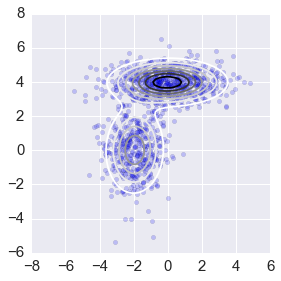

In [28]:
intervals = 101
ys = np.linspace(-8,8,intervals)
X, Y = np.meshgrid(ys, ys)
_ys = np.vstack([X.ravel(), Y.ravel()]).T

z = np.zeros(len(_ys))
for pi, mu, sigma in zip(pis1, mus1, sigmas1):
    z += pi*mvn(mu, sigma).pdf(_ys)
z = z.reshape((intervals, intervals))

ax = plt.subplot(111)
plt.scatter(xs[:,0], xs[:,1], alpha=0.2)
plt.contour(X, Y, z, N=10)
plt.axis([-8,6,-6,8])
ax.axes.set_aspect('equal')
plt.tight_layout()

In [29]:
%%time
ll2, pis2, mus2, sigmas2 = em_gmm_vect(xs, pis, mus, sigmas)

CPU times: user 26.7 ms, sys: 1.51 ms, total: 28.2 ms
Wall time: 26.7 ms


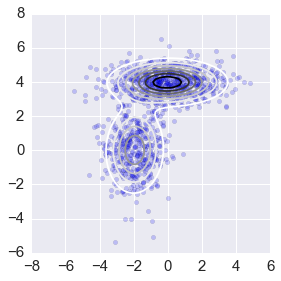

In [30]:
intervals = 101
ys = np.linspace(-8,8,intervals)
X, Y = np.meshgrid(ys, ys)
_ys = np.vstack([X.ravel(), Y.ravel()]).T

z = np.zeros(len(_ys))
for pi, mu, sigma in zip(pis2, mus2, sigmas2):
    z += pi*mvn(mu, sigma).pdf(_ys)
z = z.reshape((intervals, intervals))

ax = plt.subplot(111)
plt.scatter(xs[:,0], xs[:,1], alpha=0.2)
plt.contour(X, Y, z, N=10)
plt.axis([-8,6,-6,8])
ax.axes.set_aspect('equal')
plt.tight_layout()

In [49]:
%%time
ll3, pis3, mus3, sigmas3 = em_gmm_eins(xs, pis, mus, sigmas)

CPU times: user 26.9 ms, sys: 1.54 ms, total: 28.4 ms
Wall time: 27 ms


In [ ]:
# %timeit em_gmm_orig(xs, pis, mus, sigmas)
%timeit em_gmm_vect(xs, pis, mus, sigmas)
%timeit em_gmm_eins(xs, pis, mus, sigmas)

In [ ]:
intervals = 101
ys = np.linspace(-8,8,intervals)
X, Y = np.meshgrid(ys, ys)
_ys = np.vstack([X.ravel(), Y.ravel()]).T

z = np.zeros(len(_ys))
for pi, mu, sigma in zip(pis3, mus3, sigmas3):
    z += pi*mvn(mu, sigma).pdf(_ys)
z = z.reshape((intervals, intervals))

ax = plt.subplot(111)
plt.scatter(xs[:,0], xs[:,1], alpha=0.2)
plt.contour(X, Y, z, N=10)
plt.axis([-8,6,-6,8])
ax.axes.set_aspect('equal')
plt.tight_layout()